[사용자 정의 dataloader 작성하기](https://tutorials.pytorch.kr/recipes/recipes/custom_dataset_transforms_loader.html)

학습 목표

1. PyTorch 데이터셋 API이용해 __사용자 정의 데이터셋__ 만들기
2. 사용자 정의 __transform__ 만들기
3. 1과 2를 합쳐서 사용자 정의 __dataloader__ 만들기

필요한 패키지 (colab에는 이미 존재)\
`scikit-image` : 이미지 I/O, transform\
`pandas` : CSV 파싱

### Setup

In [4]:
# 라이브러리 불러오기

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 반응형 모드 설정(interactive on) -> default
plt.ion()

### 1. 데이터셋

얼굴 포즈 데이터셋

한 얼굴에 68개의 랜드마크 존재

[데이터셋](https://download.pytorch.org/tutorial/faces.zip) 다운로드 후 <u>data/faces/</u> 경로에 위치하게 한다.



In [13]:
!wget https://download.pytorch.org/tutorial/faces.zip
# !mkdir /data/faces/
from os import path
import zipfile

if not path.exists('/data/faces'):
    os.mkdir('/data/faces')

with zipfile.ZipFile("faces.zip","r") as zip_ref:
    zip_ref.extractall("/data/faces/")
%cd /data/faces/

--2023-07-12 14:32:58--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.72, 99.86.38.96, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip.3’

faces.zip.3         100%[===================>]   5.51M  --.-KB/s    in 0.06s   

2023-07-12 14:32:58 (94.7 MB/s) - ‘faces.zip.3’ saved [5780252/5780252]

/data/faces


In [17]:
# CSV 파일 읽기

landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


#### 1.1 이미지 표시 위한 도움 함수 작성

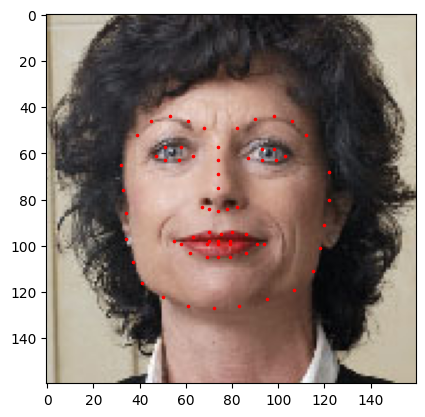

In [18]:
# 이미지가 가지고 있는 랜드마크 및 이미지 샘플 보여주기

def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(
        landmarks[:, 0],
        landmarks[:, 1],
        s=10,
        marker='.',
        c='r'
    )

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

#### 1.2 데이터셋 클래스 생성

`torch.utils.data.Dataset`: 추상 클래스, 데이터셋을 맡고 있다. `Dataset`을 상속받아야 하며 아래의 메소드들을 오버라이드 해야 한다

* `__len__` : `len(dataset)` 반환해야 함
* `__getitem__` : `dataset[i]` 의 샘플을 얻기 위해 사용된다

아래의 실습

> csv 파일은 `__init__` 에서 읽고\
> 이미지들은 `__getitem__` 에서 읽기\
> -> 이미지를 메모리에 저장하지 않고 필요할 때마다 불러오기 위함

In [26]:
class FaceLandMarksDataset(Dataset):
    def __init__(
        self,
        csv_file,
        root_dir,
        transform=None,
    ):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(
        self,
        idx,
    ):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(
            self.root_dir,
            self.landmarks_frame.iloc[idx, 0],
        )
        image = io.imread(img_name)

        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

#### 1.3 반복문을 통한 데이터 샘플 사용

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


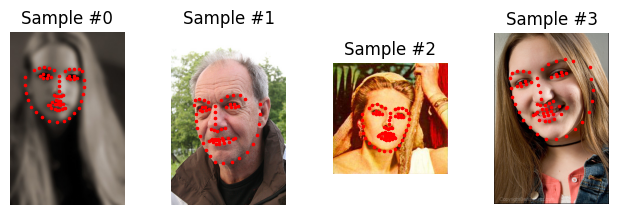

In [32]:
face_dataset = FaceLandMarksDataset(
    csv_file='faces/face_landmarks.csv',
    root_dir='faces/',
)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

### 2. 데이터 변형

* rescale: 이미지 크기 변경
* randomcrop: 무작위로 이미지 잘라내기, 데이터 증강에 사용
* ToTensor: Numpy 이미지를 파이토치 이미지로 변환

위 3개의 변형들을 호출 가능한 클래스로 만들어서 매번 변형이 호출될 때 항상 매개변수가 넘겨지지 않돌고 한다.

예)

```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

#### 2.1 호출 가능한 클래스들 작성

In [ ]:
class Rescale(object):
